#### @author: Александр Владимирович Толмачев | axtolm@gmail.com
<hr>

## 4. Методы анализа данных на Python

## Часть 2. Регрессионный анализ

### На этом занятии мы планируем научиться:
- Строить модели одномерной и многомерной линейной регрессии с помощью библиотеки statsmodels.
- Получать и интерпретировать основные показатели регрессии.
- Строить диаграммы рассеяния для анализа регрессионной модели.

### 1. Набор данных для анализа

**Для примера возьмем датасет с открытыми экономическими данными для региона Свердловская область за 2015-2018 гг**  
Файл лежит в той же папке, что документ .ipynb, поэтому путь к нему "С:/DIR/SUBDIR/.../filename.ext" можно не прописывать 

In [1]:
in_file_name = "dataset_2_linear_regression.csv"    # имя файла данных

In [2]:
import pandas as pd    # импорт библиотеки

In [3]:
df_in = pd.read_csv(in_file_name)    # выкачиваем данные из csv файла в DataFrame  

Описание метода pandas.read_csv<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [4]:
df_in.head(3)    # выведем на экран первые три строки таблицы датафрейма

,date,avg_salary,avg_pension,avg_sum_consumer_loan,n_consumer_loan,avg_card_spend
0,2015-01-15,19209,8831,192834,7173,7927
1,2015-02-15,25356,10451,201050,9291,7605
2,2015-03-15,24159,10284,200363,11937,8600


**Поля (столбцы) таблицы**<br>
- "date" - дата, для которой приведены экономические показатели, в формате str,
- "avg_salary" - средняя зарплата,
- "avg_pension" - средняя пенсия,
- "avg_sum_consumer_loan" - средняя сумма заявки на потребительский кредит,
- "n_consumer_loan" - количество заявок на потребительские кредиты,
- "avg_card_spend" - средние расходы по картам. 

### 2. Регрессионный анализ

**Регрессия (Regression)** - класс задач в рамках data analysis. Заключается в поиске функции, которая моделирует данные обучающей выборки с наименьшей ошибкой и используется для оценки взаимосвязей между данными. Формальное определение будет дано ниже.

> Регрессионный анализ тесно связан с корреляционным анализом.

### 3.1. Одномерная линейная регрессия

**Задача одномерной линейной регрессии** - для независимой переменной $X$ и зависимой переменной $Y$ нахождение линейной функции типа $Y = kX + b$ (т.е. параметров $k$ и $b$), которая будет наилучшим образом описывать связь $X$ и $Y$.   
Обучение модели - метод наименьших квадратов (МНК) - минимизация $SUM((Y_{regression} - Y_{actual})^2)$. 

**Рассмотрим для примера случай**   
Пусть исходные данные, характеризующие регион: **Средняя зарплата** (независимая переменная - $Х$)   
Хотим найти взаимосвязь и прогнозировать **Средние расходы по картам** (зависимая переменная - $Y$)

In [5]:
df_regr_simple = df_in[['date','avg_salary','avg_card_spend']].copy()    # выберем нужные колонки из исходного датасета  
df_regr_simple['date'] = pd.to_datetime(df_regr_simple['date'])  # преобразуем дату из строки в формат Timestamp 
df_regr_simple.head(3)    # выведем первые три строки на экран

,date,avg_salary,avg_card_spend
0,2015-01-15,19209,7927
1,2015-02-15,25356,7605
2,2015-03-15,24159,8600


Для визуальной оценки данных построим диаграмму рассеяния и графики временных рядов методом pandas.DataFrame.plot<br>
Можем оценить характер зависимости, наличие выбросов.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

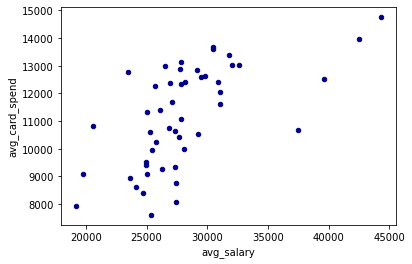

In [6]:
df_regr_simple_scatter = df_regr_simple.plot.scatter(x='avg_salary', y='avg_card_spend', c='DarkBlue') # диаграмма рассеяния

На диаграмме рассеяния есть выбросы - крайние левые 4 точки и крайние правые 4 точки.

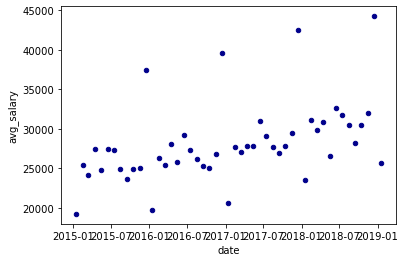

In [7]:
df_regr_simple_Xt = df_regr_simple.plot.scatter(x='date', y='avg_salary', c='DarkBlue') # график от времени

Здесь эти 4 + 4 точки выбросов тоже видны. Это зарплаты декабря (выброс вверх) и зарплаты января (выброс вниз).

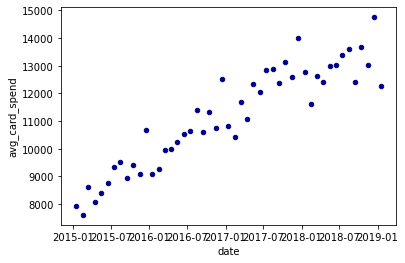

In [8]:
df_regr_simple_Yt = df_regr_simple.plot.scatter(x='date', y='avg_card_spend', c='DarkBlue') # график от времени

Сделаем еще один датасет на **df_regr_simple**, но без выбросов.<br>
Рассмотрим конструкцию:<br>
``` ~ df_regr_simple['date'].dt.month.isin([1,12]) ```
- ```df_regr_simple['date'].dt.month``` - из данных в колонке 'date' выбираем месяц,
- ```.isin([1,12])``` - пророверяем, входит ли значение в список в скобках - если входит (наш месяц январь "01" или декабрь "12"), то выдаем True, если нет - False,
- ```~``` - отрицание "не" - переворачивает логику всей конструкции в скобках и оставляет все месяцы за исключением января и декабря.

In [9]:
df_regr_simple_wo_outliers = df_regr_simple[~ df_regr_simple['date'].dt.month.isin([1,12])].copy()    # выбор без выбросов

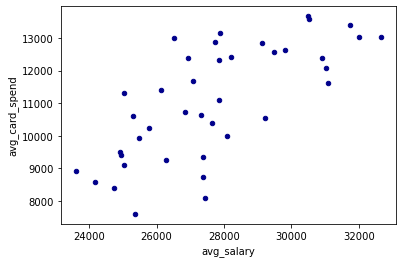

In [10]:
# снова диаграмма рассеяния
df_regr_simple_wo_outliers_scatter = df_regr_simple_wo_outliers.plot.scatter(x='avg_salary', y='avg_card_spend', c='DarkBlue') 

Все успешно, выбросы убрали.

### Построим модель одномерной линейной регрессии для выборки без выбросов

In [11]:
# импортируем необходиые библиотеки для работы с регрессионными моделями и построения графиков
import numpy as np # массивы
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Независимая переменная X**

In [12]:
x_in = df_regr_simple_wo_outliers['avg_salary'].to_numpy()
x_in

array([25356, 24159, 27430, 24726, 27387, 27372, 24915, 23616, 24943,
       25034, 26279, 25465, 28096, 25785, 29226, 27309, 26138, 25292,
       25034, 26843, 27635, 27086, 27848, 27844, 31040, 29119, 27730,
       26935, 27878, 29497, 31087, 29799, 30914, 26519, 32646, 31752,
       30510, 28198, 30497, 31997], dtype=int64)

**Зависимая переменная Y**

In [13]:
y_in = df_regr_simple_wo_outliers['avg_card_spend'].to_numpy()
y_in

array([ 7605,  8600,  8085,  8413,  8748,  9353,  9504,  8925,  9417,
        9095,  9265,  9946,  9981, 10227, 10539, 10643, 11399, 10607,
       11316, 10737, 10407, 11680, 11085, 12327, 12064, 12842, 12871,
       12388, 13137, 12580, 11625, 12623, 12394, 13000, 13018, 13379,
       13591, 12417, 13659, 13012], dtype=int64)

**Показатели регрессии**  
OLS - Ordinary Least Squares regression

In [14]:
x_in = sm.add_constant(x_in)    # преобразование входного массива независимой переменной
est = sm.OLS(y_in, x_in)    # создание модели
est2 = est.fit()    # расчет показателей модели
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     38.34
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           3.10e-07
Time:                        10:38:40   Log-Likelihood:                -340.67
No. Observations:                  40   AIC:                             685.3
Df Residuals:                      38   BIC:                             688.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3401.3855   2344.016     -1.451      0.1

**Коэффициент детерминации** $R^2$ характеризует долю дисперсии результативного признака $Y_{regression}$ (объясняемую регрессией) в общей дисперсии $Y_{actual}$ (наблюдаемые значения). Используется для оценки модели. Коэффициент детерминации равен квадрату коэффициента корреляции между наблюдаемыми и предсказанными (регрессионными) значениями.

Оценка значимости полученных параметров регрессии по величине p-value.<br>
Статистическая гипотеза линейной регрессии: $H_0$ - параметры регрессии  $k$  и  $b$ значимо не отличается от нуля.

**Для оценки полученных результатов вычислим значения $Y_{regression}$**

In [15]:
y_predict = est2.predict()
y_predict

array([ 9851.37044109,  9225.73749813, 10935.38274159,  9522.0899448 ,
       10912.90804105, 10905.06802923,  9620.87409368,  8941.92907037,
        9635.50878241,  9683.07152076, 10333.79250153,  9908.34119362,
       11283.47926624, 10075.59477904, 11874.09348976, 10872.1399796 ,
       10260.09639046,  9817.91972401,  9683.07152076, 10628.57694584,
       11042.52956975, 10755.58513726, 11153.85773754, 11151.76706773,
       12822.2122521 , 11818.16807213, 11092.18297792, 10676.66235164,
       11169.53776118, 12015.73636991, 12846.77762246, 12173.58194115,
       12756.35615284, 10459.2326906 , 13661.61618393, 13194.35147966,
       12545.19850125, 11336.7913466 , 12538.40382434, 13322.405006  ])

**Фактические значения $Y_{actual}$ были**

In [16]:
y_in

array([ 7605,  8600,  8085,  8413,  8748,  9353,  9504,  8925,  9417,
        9095,  9265,  9946,  9981, 10227, 10539, 10643, 11399, 10607,
       11316, 10737, 10407, 11680, 11085, 12327, 12064, 12842, 12871,
       12388, 13137, 12580, 11625, 12623, 12394, 13000, 13018, 13379,
       13591, 12417, 13659, 13012], dtype=int64)

**Построим диаграмму рассеяния и график идеального прогноза с помощью matplotlib**  
https://matplotlib.org/stable/tutorials/introductory/pyplot.html

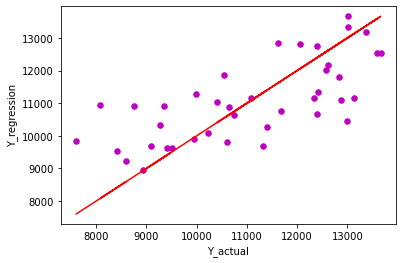

In [17]:
# Диаграмма рассеяния
plt.scatter(y_in, y_predict, color = "m", marker = "o", s = 30) # построим просто точки
# добавим линию идеального прогноза (диагональ)
plt.plot(y_in, y_in, color = "r") 
# подписи осей на график
plt.xlabel('Y_actual') 
plt.ylabel('Y_regression') 
# выводим график
plt.show()

### Каким был бы результат, если бы не убрали выбросы?

In [18]:
x_in_1 = df_regr_simple['avg_salary'].to_numpy()
y_in_1 = df_regr_simple['avg_card_spend'].to_numpy()
x_in_1 = sm.add_constant(x_in_1)
est_1 = sm.OLS(y_in_1, x_in_1) 
est2_1 = est_1.fit()
print(est2_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     28.61
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           2.56e-06
Time:                        10:38:40   Log-Likelihood:                -425.26
No. Observations:                  49   AIC:                             854.5
Df Residuals:                      47   BIC:                             858.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4706.2393   1225.992      3.839      0.0

In [19]:
y_predict_1 = est2_1.predict()

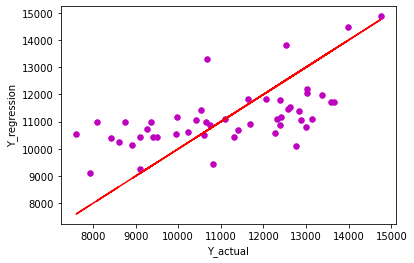

In [20]:
# Диаграмма рассеяния
plt.scatter(y_in_1, y_predict_1, color = "m", marker = "o", s = 30) # построим просто точки
# добавим линию идеального прогноза (диагональ)
plt.plot(y_in_1, y_in_1, color = "r") 
# подписи осей на график
plt.xlabel('Y_actual') 
plt.ylabel('Y_regression') 
# выводим график
plt.show()

### 3.2. Корреляция "avg_salary	- avg_card_spend" с выбросами и без

In [21]:
df_regr_simple_corr = df_regr_simple.corr()    # с выбросами
df_regr_simple_corr

,avg_salary,avg_card_spend
avg_salary,1.000000,0.615139
avg_card_spend,0.615139,1.000000


In [22]:
df_regr_simple_wo_outliers_corr = df_regr_simple_wo_outliers.corr()    # без выбросов
df_regr_simple_wo_outliers_corr

,avg_salary,avg_card_spend
avg_salary,1.000000,0.708702
avg_card_spend,0.708702,1.000000


### После исключения выбросов:
- коэффициент корреляции увеличился $0.62 => 0.71$
- коэффициент детерминации $R^2$ увеличился $0.38 => 0.50$

Вывод - выбросы оказывают существенное влияние на корреляционную и регрессионную связи.

### 3.3. Многомерная линейная регрессия

**Задача многомерной линейной регрессии** - для набора независимых переменных - $Х_{1}$, $Х_{2}$,...$Х_{n}$ и зависимой переменной $Y$ нахождение линейной функции типа $Y = k_{1}X_{1} + k_{2}X_{2} + ... + k_{n}X_{n} + b$ (т.е. параметров $k_{i}, b$), которая будет наилучшим образом описывать связь $Х_{1}$, $Х_{2}$,...$Х_{n}$ и $Y$. 
Обучение модели - метод наименьших квадратов (МНК) - минимизация $SUM((Y_{regression} - Y_{actual})^2)$.  

**Рассмотрим для примера случай**   
Пусть исходные данные, характеризующие регион: 
- средняя зарплата ($X_1$), 
- средняя пенсия ($X_2$), 
- средняя сумма заявки на потребительский кредит ($X_3$),
- количество заявок на потребительские кредиты ($X_4$).

Это набор независимых переменных - $Х_i$   
Хотим найти взаимосвязь и прогнозировать **Средние расходы по картам** (зависимая переменная - $Y$)

In [23]:
df_regr_multivar = df_in.copy()    # выберем все колонки из исходного датасета  
df_regr_multivar['date'] = pd.to_datetime(df_regr_multivar['date'])  # преобразуем дату из строки в формат Timestamp 
df_regr_multivar.head(3)    # выведем первые три строки на экран

,date,avg_salary,avg_pension,avg_sum_consumer_loan,n_consumer_loan,avg_card_spend
0,2015-01-15,19209,8831,192834,7173,7927
1,2015-02-15,25356,10451,201050,9291,7605
2,2015-03-15,24159,10284,200363,11937,8600


**Для оценки данных на предмет выбросов построим графики временных рядов с помощью метода plot** 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

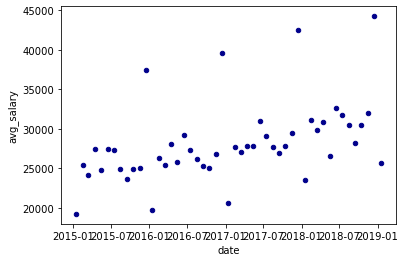

In [24]:
df_regr_multivar_X1t = df_regr_multivar.plot.scatter(x='date', y='avg_salary', c='DarkBlue') # график от времени

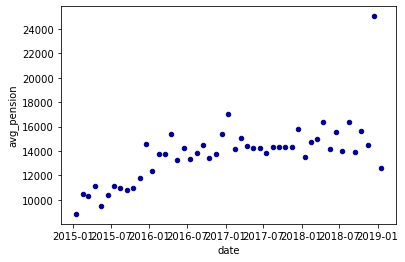

In [25]:
df_regr_multivar_X2t = df_regr_multivar.plot.scatter(x='date', y='avg_pension', c='DarkBlue') # график от времени

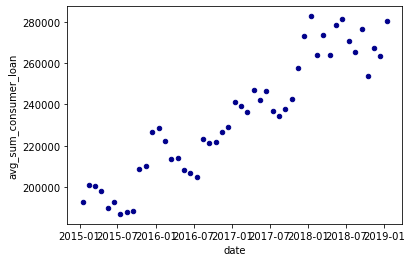

In [26]:
df_regr_multivar_X3t = df_regr_multivar.plot.scatter(x='date', y='avg_sum_consumer_loan', c='DarkBlue') # график от времени

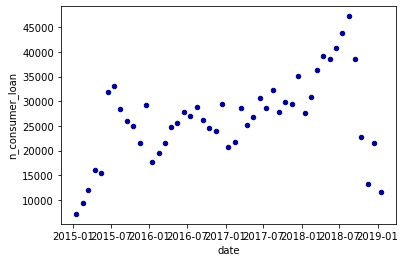

In [27]:
df_regr_multivar_X4t = df_regr_multivar.plot.scatter(x='date', y='n_consumer_loan', c='DarkBlue') # график от времени

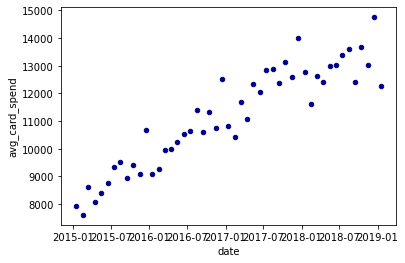

In [28]:
df_regr_multivar_Yt = df_regr_multivar.plot.scatter(x='date', y='avg_card_spend', c='DarkBlue') # график от времени

Выбросы видны на глаз, хотя правильнее применить формальные методы, но это не есть тема данного занятия.<br>
Выполним многомерный регрессионный анализ, не исключая выбросы.  

### Построим модель многомерной линейной регрессии

In [29]:
# импортируем необходиые библиотеки для работы с регрессионными моделями и построения графиков
import numpy as np # массивы
import statsmodels.api as sm
import matplotlib.pyplot as plt 

**Независимые переменные $X_i$**

In [30]:
x_in_m = df_regr_multivar[['avg_salary','avg_pension','avg_sum_consumer_loan','n_consumer_loan']].to_numpy()
x_in_m[:3]

array([[ 19209,   8831, 192834,   7173],
       [ 25356,  10451, 201050,   9291],
       [ 24159,  10284, 200363,  11937]], dtype=int64)

**Зависимая переменная Y**

In [31]:
y_in_m = df_regr_multivar['avg_card_spend'].to_numpy()
y_in_m

array([ 7927,  7605,  8600,  8085,  8413,  8748,  9353,  9504,  8925,
        9417,  9095, 10674,  9095,  9265,  9946,  9981, 10227, 10539,
       10643, 11399, 10607, 11316, 10737, 12523, 10813, 10407, 11680,
       11085, 12327, 12064, 12842, 12871, 12388, 13137, 12580, 13980,
       12758, 11625, 12623, 12394, 13000, 13018, 13379, 13591, 12417,
       13659, 13012, 14747, 12280], dtype=int64)

**Показатели регрессии**  
OLS - Ordinary Least Squares regression

In [32]:
x_in_m = sm.add_constant(x_in_m)
est_m = sm.OLS(y_in_m, x_in_m) 
est2_m = est_m.fit()
print(est2_m.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     61.12
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           2.12e-17
Time:                        10:38:44   Log-Likelihood:                -390.84
No. Observations:                  49   AIC:                             791.7
Df Residuals:                      44   BIC:                             801.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1839.9212    916.683     -2.007      0.0

**Коэффициент детерминации** $R^2$ характеризует долю дисперсии результативного признака $Y_{regression}$ (объясняемую регрессией) в общей дисперсии $Y_{actual}$ (наблюдаемые значения). Используется для оценки модели. Коэффициент детерминации равен квадрату коэффициента корреляции между наблюдаемыми и предсказанными (регрессионными) значениями.

Оценка значимости полученных параметров регрессии по величине p-value.<br>
Статистическая гипотеза линейной регрессии: $H_0$ - параметры регрессии  $k_i$  и  $b$ (const) значимо не отличается от нуля.

**Для оценки полученных результатов вычислим значения $Y_{regression}$**

In [33]:
y_predict_m = est2_m.predict()
y_predict_m

array([ 7656.32047941,  8633.66237054,  8617.643765  ,  9022.99681753,
        8275.83895456,  9287.02247442,  9272.28849401,  8974.3016765 ,
        8808.54681835,  9569.48565183,  9636.36824295, 11653.71428221,
        9958.16563078, 10400.76308044, 10132.56752351, 10720.37928509,
       10020.40387337, 10417.39493094, 10074.32546844, 10784.30788976,
       10698.57343489, 10442.22339307, 10747.38529945, 12002.66887778,
       11413.93847661, 11208.08527866, 11526.69598513, 11661.52316327,
       11537.2855937 , 11999.97425086, 11403.82830617, 11474.67113675,
       11382.95371679, 11675.65736319, 12266.31803426, 13965.69383667,
       12593.86401234, 12694.44017951, 13207.86363995, 13302.00711681,
       13147.89594256, 13883.50443118, 13305.87785179, 13639.25102509,
       13106.83142811, 12174.2122964 , 12150.70151238, 14918.95888593,
       11851.61782108])

**Фактические значения $Y_{actual}$ были**

In [34]:
y_in_m

array([ 7927,  7605,  8600,  8085,  8413,  8748,  9353,  9504,  8925,
        9417,  9095, 10674,  9095,  9265,  9946,  9981, 10227, 10539,
       10643, 11399, 10607, 11316, 10737, 12523, 10813, 10407, 11680,
       11085, 12327, 12064, 12842, 12871, 12388, 13137, 12580, 13980,
       12758, 11625, 12623, 12394, 13000, 13018, 13379, 13591, 12417,
       13659, 13012, 14747, 12280], dtype=int64)

**Построим диаграмму рассеяния и график идеального прогноза с помощью matplotlib**  
https://matplotlib.org/stable/tutorials/introductory/pyplot.html

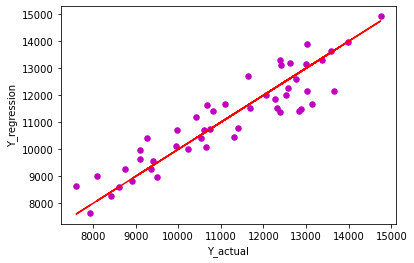

In [35]:
# Диаграмма рассеяния
plt.scatter(y_in_m, y_predict_m, color = "m", marker = "o", s = 30) # построим просто точки
# добавим линию идеального прогноза (диагональ)
plt.plot(y_in_m, y_in_m, color = "r") 
# подписи осей на график
plt.xlabel('Y_actual') 
plt.ylabel('Y_regression') 
# выводим график
plt.show() 

### Подведем итоги. На этом занятии мы научились:
- Строить модели одномерной и многомерной линейной регрессии с помощью библиотеки statsmodels.
- Получать и интерпретировать основные показатели регрессии.
- Строить диаграммы рассеяния для анализа регрессионной модели.